In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

# Load in Tables
- and dictionary of peaks

In [2]:
#file names of part 2 objects
cross2 = Table.read('part2files.csv')
#table with all objects w/ additional info (est. period)
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

#summary table
summ = pd.read_csv('summtab.csv')

#dictionary for LS peaks in pulsating sources
peaks = np.load('part1peaks.npy',allow_pickle='TRUE').item()

In [6]:
cross = Table.read('sourcefiles.csv')

In [3]:
summ[:10]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V V-I slope,V V-I int,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd
0,1,19.271511,-73.443405,0.717,0.5,3.892,0.404107,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,20.418930,-72.959070,2.165,2.0,84.000,2.147143,NaN,14.379506,0.356251,...,-1.314422,14.446890,no,NaN,revisit alias and 6.8,0.768988,-1.033376,-1.537777,1.704585,83.985070
2,3,13.639167,-73.683640,2.370,0.8,18.380,0.259701,NaN,14.877813,0.267369,...,-2.085944,15.032918,yes,NaN,NaN,1.698965,2.086592,1.458121,0.808846,17.404354
3,4,14.797429,-71.645960,2.763,7.5,82.370,0.000000,NaN,13.919472,0.042264,...,0.309888,14.047180,yes,0.030,doesn’t follow Corbet,1.061946,0.298944,0.799828,1.009136,81.891818
4,5,12.913330,-72.284330,4.780,1.4,0.000,0.000000,NaN,15.549296,0.044747,...,0.169220,15.667252,no,0.133,NaN,-0.257503,1.181314,-0.241179,0.598523,2.233790
5,6,14.259583,-72.431880,5.050,0.5,17.130,0.902515,SXP 5.05,15.905905,0.095154,...,-0.650323,16.017303,yes,0.300,changed est. 17.2 to 17.13,-1.266705,0.786946,-1.381626,0.596449,17.347929
6,7,15.722455,-72.742990,6.850,0.5,21.900,0.421283,NaN,14.721636,0.219999,...,-1.698528,14.762223,NaN,NaN,NaN,1.011883,0.099615,0.927689,-0.508443,23.961722
7,8,13.541667,-72.428890,6.878,204.0,0.000,0.000000,NaN,16.444344,0.043925,...,-0.110847,18.058648,NaN,NaN,NaN,-0.101434,-1.653546,-0.182664,-1.080367,6.228457
8,9,13.023750,-72.434450,7.780,0.6,44.920,0.136825,NaN,14.768247,0.063653,...,-0.921314,15.075968,yes,0.340,NaN,-2.198561,8.803889,-2.319572,10.989067,44.901697
9,10,14.493333,-72.374860,7.920,1.5,40.030,1.214530,SXP 7.92,15.863079,0.060680,...,0.566228,15.822570,yes,NaN,NaN,-1.586341,3.237692,0.982469,0.053194,39.834982


# For Example, Grab Superorbital Peaks Above x Power
- and can use lower ones to check for beats/aliasing

In [4]:
peaks[2][2] #source number then index 2 for superorbital periodogram

,period,power
0,2141.876248,0.266863
1,404.866852,0.246377
2,331.990818,0.209686


note that the superorbital powers are often easily high 

In [5]:
#source 15 looks to have ~regular flaring
peaks[15][2] #notice nothing close to that, which helps show no changes

,period,power
0,810.593956,0.415739


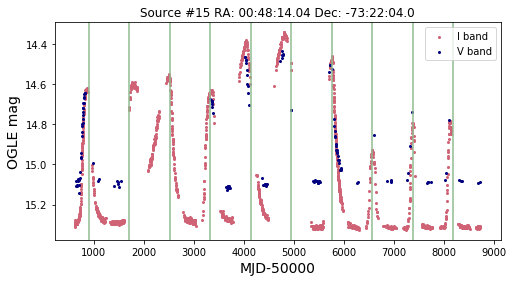

In [10]:
#now grab LC and space lines by peak
iband,vband = o.getIV(15,cross,plot=True,zooms=False,figsize=(8,4),mult=(3,8),offset=10,stack=True,save=False)
for i in range(10):
    plt.axvline(900+810.59*i,color='darkseagreen')

close, but not exactly constant
- amplitude-dependent?

# Compare Part 1 and Part 2 Sources

In [14]:
#add column with part
# summ['Part'] = np.zeros(len(summ))
# for s in range(len(summ)):
#     if summ['src_n'][s] in cross['src_n']:
#         summ['Part'][s] = 1
#     elif summ['src_n'][s] in cross2['src_n']:
#         summ['Part'][s] = 2

In [15]:
summ.head()

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V V-I int,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part
0,1,19.271511,-73.443405,0.717,0.5,3.892,0.404107,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
1,2,20.418930,-72.959070,2.165,2.0,84.000,2.147143,NaN,14.379506,0.356251,...,14.446890,no,NaN,revisit alias and 6.8,0.768988,-1.033376,-1.537777,1.704585,83.985070,1.0
2,3,13.639167,-73.683640,2.370,0.8,18.380,0.259701,NaN,14.877813,0.267369,...,15.032918,yes,NaN,NaN,1.698965,2.086592,1.458121,0.808846,17.404354,1.0
3,4,14.797429,-71.645960,2.763,7.5,82.370,0.000000,NaN,13.919472,0.042264,...,14.047180,yes,0.030,doesn’t follow Corbet,1.061946,0.298944,0.799828,1.009136,81.891818,1.0
4,5,12.913330,-72.284330,4.780,1.4,0.000,0.000000,NaN,15.549296,0.044747,...,15.667252,no,0.133,NaN,-0.257503,1.181314,-0.241179,0.598523,2.233790,1.0


In [16]:
#write out new table with this addition
# summ.to_csv('summtab.csv',index=False)

In [17]:
part1 = summ[summ['Part']==1]
part2 = summ[summ['Part']==2]

In [20]:
part1[part1==0] = np.nan #replace 0s with nans so they don't plot
part2[part2==0] = np.nan

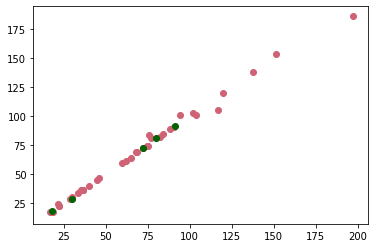

In [22]:
plt.scatter(part1['est. period'],part1['best auto det pd'],color=pink)
plt.scatter(part2['est. period'],part2['best auto det pd'],color='darkgreen')

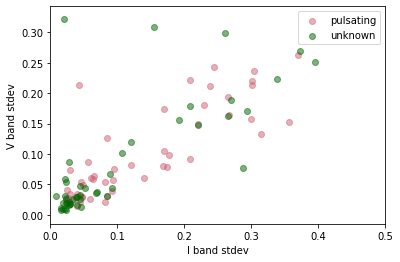

In [27]:
plt.scatter(part1['stdev I'],part1['stdev V'],color=pink,alpha=0.5,label='pulsating')
plt.scatter(part2['stdev I'],part2['stdev V'],color='darkgreen',alpha=0.5,label='unknown')
#cut out outlier from part 2
plt.xlim(0,0.5)
plt.ylabel('V band stdev')
plt.xlabel('I band stdev')
plt.legend()

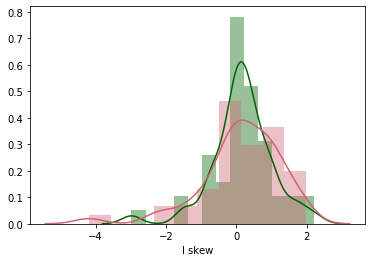

In [31]:
sb.distplot(part2['I skew'],color='darkgreen',label='unknown')
sb.distplot(part1['I skew'],color=pink,label='pulsating')

negative skew = skewed to larger values = fainter values

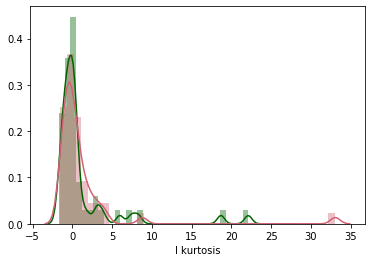

In [32]:
sb.distplot(part2['I kurtosis'],color='darkgreen',label='unknown')
sb.distplot(part1['I kurtosis'],color=pink,label='pulsating')

In [33]:
summ.columns

Index(['src_n', 'ra_deg', 'dec_deg', 'spin period', 'perr', 'est. period',
       'sep', 'name', 'mean I', 'stdev I', 'max I', 'min I', 'I range',
       'mean V', 'stdev V', 'max V', 'min V', 'V range', 'est. period method',
       'best period', 'best superorbital', 'other period', 'period shape',
       'big dip', 'orbital cont', 'superorbital cont', 'mult superorbital',
       'changing superorbital amp', 'redder when brighter', 'I V-I corr',
       'V V-I corr', 'I V-I slope', 'I V-I int', 'V V-I slope', 'V V-I int',
       'V-I transition', 'Type II amp', 'note', 'I skew', 'I kurtosis',
       'V skew', 'V kurtosis', 'best auto det pd', 'Part'],
      dtype='object')

In [40]:
#temp summary table without outliers
tsumm=summ
tsumm[tsumm['stdev I']>0.5]=np.nan
tsumm[tsumm['I kurtosis']>10]=np.nan
tsumm[tsumm['V kurtosis']>10]=np.nan
tsumm[tsumm['I range']>2]=np.nan

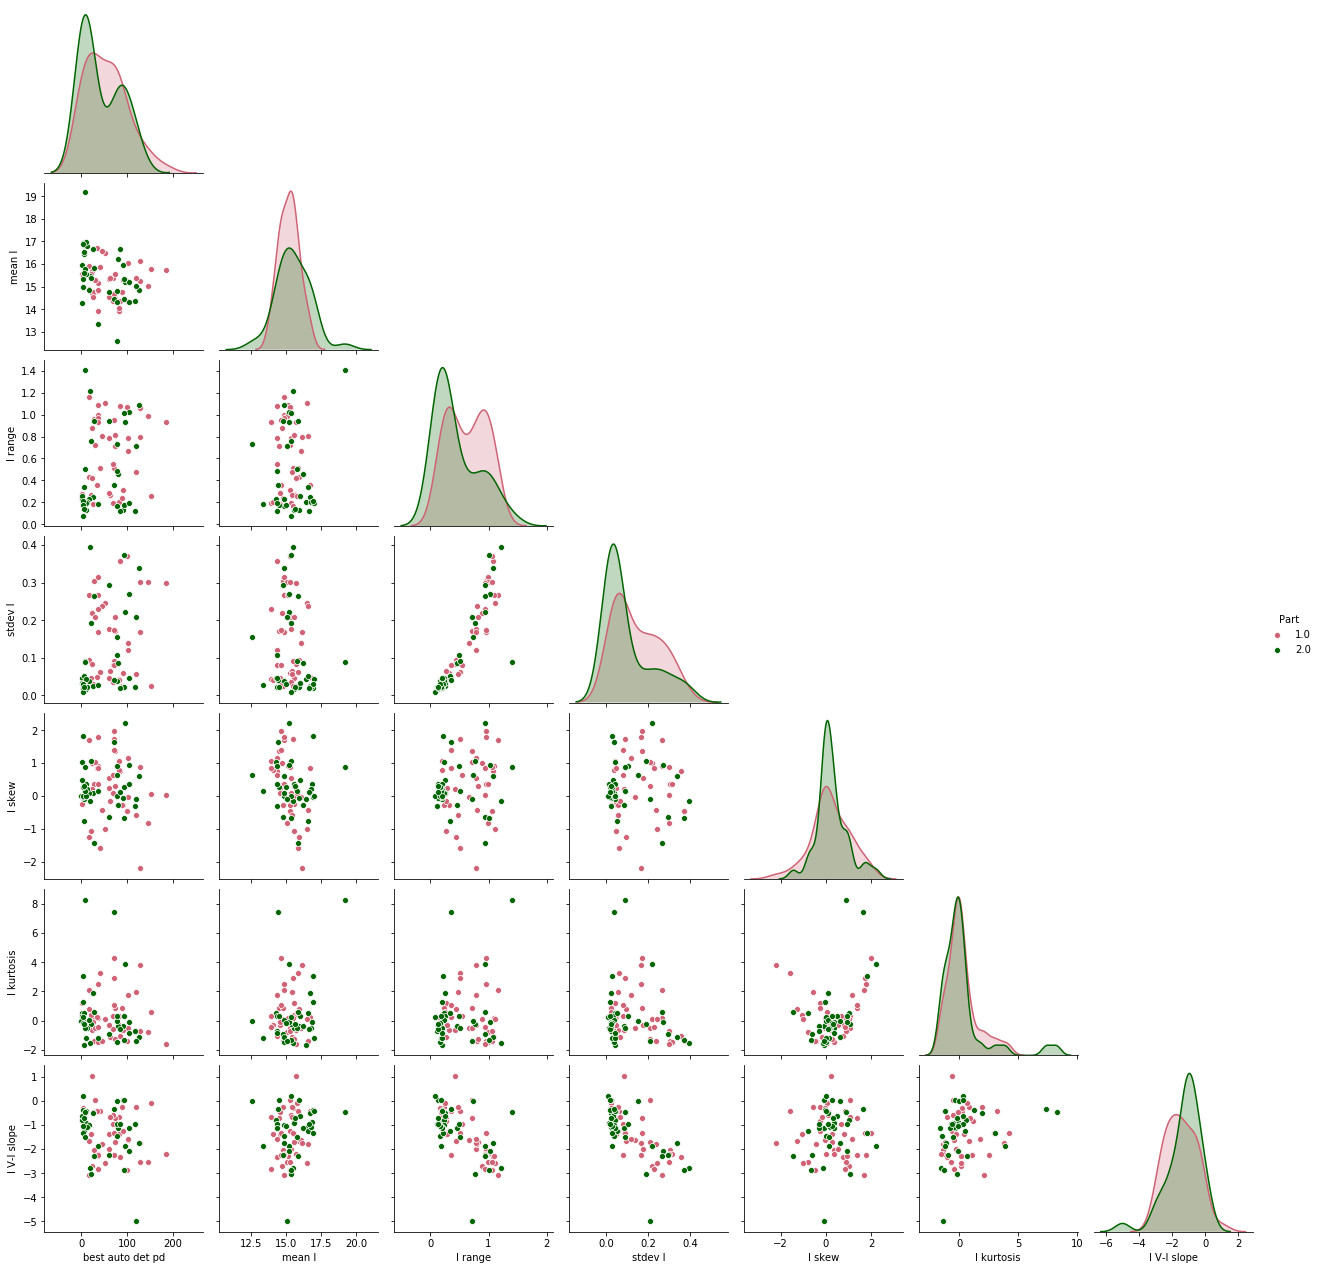

In [42]:
c = sb.pairplot(tsumm,vars=['best auto det pd','mean I','I range','stdev I','I skew','I kurtosis','I V-I slope'],
            hue='Part',corner=True,palette=[pink,'darkgreen'])
plt.savefig('Figs/cornerplot.png',dpi=200,bbox_inches='tight')